# **HOMEWORK 2: SYSTEMS IDENTIFICATION**

In [1]:
#!pip install -q tellurium
#!pip install -q control
#!pip install -q controlSBML
import numpy as np
import tellurium as te
import controlSBML as ctl
import control
import matplotlib.pyplot as plt

# Helpers

In [2]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 10, 100)

In [3]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
TEST_RR = te.loada(TEST_MODEL)

In [4]:

k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
scale = TEST_RR["S1"]
tf = scale*k1*k2/(s*(s+k2))

In [5]:
def evaluateTransferFunction(model, transfer_function, output_name, times=TIMES,
                             is_plot=True):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony
        tranfer_function (control.TransferFunction)
        output_name: (str) prediction
        times: (np.darray)
    Returns:
        float
    """
    rr = te.loada(model)
    data = rr.simulate(times[0], times[-1], len(times))
    output_name = "[" + output_name + "]"
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        plt.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        plt.plot([0, maxval], [0, maxval], color="red")
        plt.xlabel("simulated")
        plt.ylabel("predicted")
    return rmse

rmse = evaluateTransferFunction(TEST_MODEL, tf, "S3", is_plot=False)
assert(rmse < 1e-5)
print("OK!")

OK!


In [6]:
def plotModel(model, times=TIMES, is_plot=True, title="", **kwargs):
    """
    Plots a model.
    
    Args:
       times: np.array 
       kwargs: values of parameters
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    rr.simulate(times[0], times[-1], len(times))
    if is_plot:
        rr.plot(title=title)
    
# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False)
print("OK1")

OK1


# Problem 1 (15 pt): Find the transfer function for a network

This network implements negative feedback. The first 3 reactions describe a 3 species sequential network; the input is $S_1$ and the output is $S_3$. The last reaction implements negative feedback by degrading $S_2$ at a rate proportional to $S_3$. (Note that the last reaction is *not* mass action.)


\begin{eqnarray}
S_1 & \xrightarrow{k_1 S_1} & S_2 \\
S_2 & \xrightarrow{k_2 S_2}&  S_3 \\
S_3 & \xrightarrow{k_3 S_3}&  \emptyset \\
\end{eqnarray}

\begin{eqnarray}
S_2 & \xrightarrow{k_4 S_3 }&  \emptyset \\
\end{eqnarray}

1.(1 pt)  Write the Laplace transforms of the system equations.

\begin{eqnarray}
s S_2 (s) & = & k_1 S_1(s) - k_2 S_2(s) - k_4 S_3 (s) \\
s S_3 (s) & = & k_2 S_2(s) - k_3 S_3(s) \\
\end{eqnarray}

2. (4 pt) Find $G(s) = \frac{S_3 (s)}{S_1 (s)}$ (5 pt)

\begin{eqnarray}
S_2 (s) & = & \frac{k_1 }{s + k_2} S_1 (s) - \frac{k_4}{s + k_2} S_3(s) \\
S_3 (s) & = &  \frac{k_2 }{s + k_3} S_2 (s) \\
 & = &  \frac{k_2 }{s + k_3} \left( \frac{k_1 }{s + k_2} S_1 (s) - \frac{k_4}{s + k_2} S_3(s) \right) \\
\end{eqnarray}

\begin{eqnarray}
(s+k_2)(s + k_3) S_3 (s) & = &  k_1 k_2 S_1 (s) - k_2 k_4 S_3(s)  \\
 S_3 (s) & = &  \frac{k_1 k_2 S_1 (s)}{ k_2 k_4 + (s+k_2)(s + k_3)} \\
  G (s) & = &  \frac{k_1 k_2 }{s^2 + (k_2 + k_3) s + k_2 k_3 + k_2 k_4 } \\
\end{eqnarray}

3. (5 pt) What is the characteristic equation? What is the DC gain? What is required to have the DC gain be 1 so that $S_3$ will have the same concentration as $S_1$?

1. Characteristic equation: $s^2 + (k_2 + k_3) s + k_2 k_3 + k_2 k_4  = 0$
1. DC gain: $\frac{k_1}{k_3 + k_4}$
1. DC gain is one if $k_1 = k_3 + k_4$

4. (5 pt) Show that you have the correct solution by comparing the predictions of the transfer function with those of simulation for $k_i = 1$.

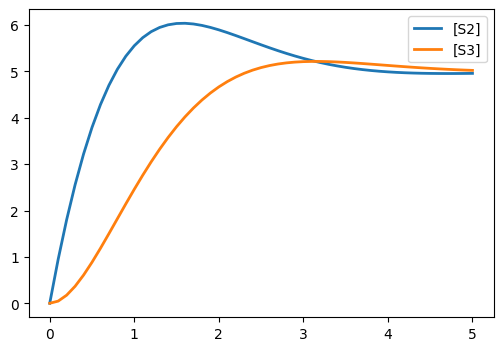

In [7]:
model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3
S2 -> ; k4*S3
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
k1 = 1
k2 = 1
k3 = 1
k4 = 1
"""
RR = te.loada(model)
RR.simulate()
RR.plot()

In [8]:
k1 = RR["k1"]
k2 = RR["k2"]
k3 = RR["k3"]
k4 = RR["k4"]
scale = RR["S1"]
tf = scale*(k1*k2)/(s**2 + (k2 + k3)*s + k2*k3 + k2*k4)
tf

TransferFunction(array([10.]), array([1., 2., 2.]))

9.196012053722113e-07

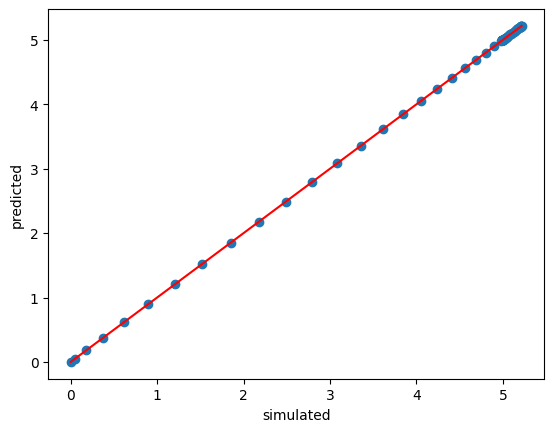

In [9]:
evaluateTransferFunction(model, tf, "S3")

# Problem 2: (10 pt) Do system identification

Use ``controlSBML.plotTransferFunctionFit`` to do system identification for the system you analyzed in homework 1.